In [158]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [159]:
import numpy as np
import pandas as pd

In [160]:
import datetime as dt

In [161]:
import sqlalchemy as db
from sqlalchemy import and_
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [162]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [163]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [164]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [165]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [166]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [167]:
inspector = inspect(engine)
columns = inspector.get_columns('Measurement')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [168]:
columns = inspector.get_columns('Station')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [169]:
query_test = engine.execute('SELECT * FROM measurement LIMIT 10').fetchall()

In [170]:
query_test

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0),
 (6, 'USC00519397', '2010-01-07', 0.06, 70.0),
 (7, 'USC00519397', '2010-01-08', 0.0, 64.0),
 (8, 'USC00519397', '2010-01-09', 0.0, 68.0),
 (9, 'USC00519397', '2010-01-10', 0.0, 73.0),
 (10, 'USC00519397', '2010-01-11', 0.01, 64.0)]

In [171]:
#Exploratory Climate Analysis

In [172]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
query = [func.sum(Measurement.prcp).label('prcp'),
        func.extract('month', Measurement.date).label('date')]


In [173]:
last_12 = session.query(*query).\
    filter(Measurement.date.between('2016-08-23', '2017-07-23')).\
    group_by(func.extract('month', Measurement.date)).all()

In [174]:
precip_df = pd.DataFrame(last_12, columns=['prcp', 'date'])
precip_df

,prcp,date
0,11.95,1
1,39.06,2
2,29.62,3
3,54.91,4
4,25.27,5
5,20.52,6
6,17.65,7
7,20.81,8
8,49.40,9
9,21.77,10


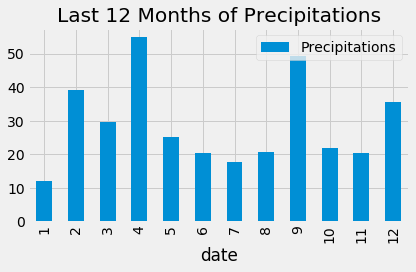

In [175]:
precip_df.plot.bar(x='date', y='prcp', title ='Last 12 Months of Precipitations', label='Precipitations')
plt.tight_layout()
plt.legend(loc = 'best')
plt.show()

In [176]:
last_year = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_year

('2017-08-23')

In [154]:
# Calculate the date 1 year ago from the last data point in the database
prev_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
prev_year

datetime.date(2016, 8, 23)

In [155]:
# Perform a query to retrieve the data and precipitation scores
date_prec_cols = [Measurement.prcp, Measurement.date]
date_prec_query = session.query(*date_prec_cols).\
    filter(Measurement.date.between('2016-08-23', '2017-08-23')).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
date_prec_df = pd.DataFrame(date_prec_query, columns=['Precipitation', 'Date'])
date_prec_df.set_index('Date').head()

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02


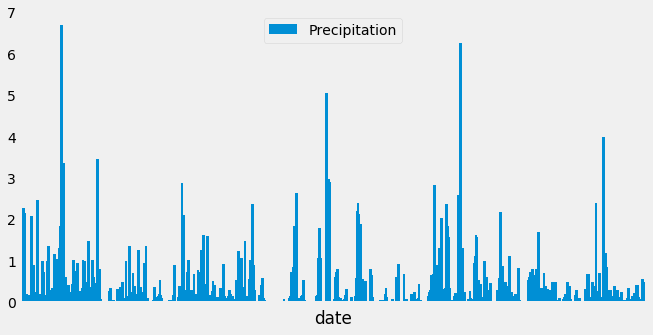

In [156]:
# Use Pandas Plotting with Matplotlib to plot the data
ax_pandas = date_prec_df.plot.bar(figsize=(10,5), width=10.0)
ax_pandas.set_xticklabels([''])
plt.xlabel('date')
plt.legend(loc='upper center')
plt.grid()
plt.show()

In [157]:
# Use Pandas to calcualte the summary statistics for the precipitation data
date_prcp_df.describe()

,Precipitation
count,1951.000000
mean,0.181246
std,0.468249
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [133]:
# Design a query to show how many stations are available in this dataset?
session.query(Measurement.station).group_by(Measurement.station).count()

9

In [188]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_cols = [Measurement.station, func.count(Measurement.station).label('Total_Station')]
station_query = session.query(*station_cols).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
station_query


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [179]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
station_temp_cols = [func.max(Measurement.tobs),
                    func.min(Measurement.tobs),
                    func.avg(Measurement.tobs)]
station_temp_query = session.query(*station_temp_cols).all()
station_temp_query

[(87.0, 53.0, 73.09795396419437)]

In [180]:
# Choose the station with the highest number of temperature observations.
max_station = 'USC00519281'
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_year_temp_col = [Measurement.tobs]
last_year_temp_query = session.query(*last_year_temp_col).\
                        filter(Measurement.date.between('2016-08-23', '2017-08-23')).all()
last_year_temp_df = pd.DataFrame(last_year_temp_query, columns=['tobs'])

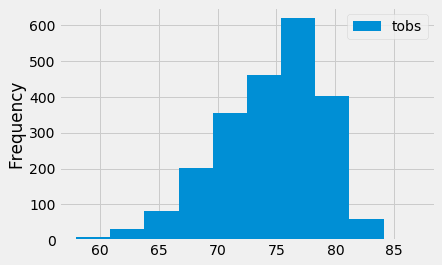

In [186]:
last_year_temp_df.plot.hist()
plt.show()

In [189]:
from flask import Flask, jsonify

In [190]:
app = Flask(__name__)

In [191]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [192]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2014-05-25', '2015-05-25'))


[(56.0, 73.27644514353126, 85.0)]


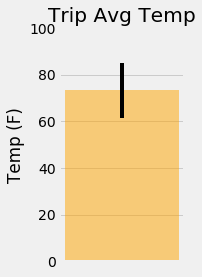

In [193]:

# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

start_date = '2014-05-25'
end_date = '2015-05-25'
list_temp = calc_temps(start_date, end_date)
#list_temp = calc_temps('2012-02-28', '2012-03-05')

x_pos = len(list_temp)
#tmin = list_temp[0][0]
tavg = list_temp[0][1]
#tmax = list_temp[0][2]
tstd = np.std(list_temp)

fig, ax = plt.subplots(figsize=(2,4))
ax.bar(x_pos, tavg, yerr=tstd, align='center', alpha=0.5, ecolor='black', color='orange')
plt.title('Trip Avg Temp')
plt.ylabel('Temp (F)')
ax.set_xticklabels([''])
ax.set_yticks([x for x in range(0,120,20)])
plt.grid(axis='x')
plt.show()

In [194]:

# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rainfall_cols = [Station.station, 
                 Station.name,
                 Station.latitude,
                 Station.longitude,
                 Station.elevation,
                 Measurement.prcp]
rainfall_query = session.query(*rainfall_cols).\
                filter(Measurement.station == Station.station).\
                filter(Measurement.date.between(start_date, end_date)).\
                order_by(Measurement.prcp.desc()).all()

rainfall_df = pd.DataFrame(rainfall_query, columns=['Station', 'Name', 'Latitud', 'Longitu', 'Elevation', 'Precipitation'])
rainfall_df.head()

,Station,Name,Latitud,Longitu,Elevation,Precipitation
0,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,11.53
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,7.97
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,5.98
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,5.54
4,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,4.30


In [195]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [196]:
# calculate the daily normals for your trip
normals = []
for _ in range(25,31):
    date_tuple = "05-" + str(_)
    print(daily_normals(date_tuple)[0])
    normals.append(daily_normals(date_tuple)[0])
    #normals += (daily_normals(date_tuple),)
# push each tuple of calculations into a list called `normals`
normals
# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date

(68.0, 74.27586206896552, 79.0)
(65.0, 74.03636363636363, 82.0)
(65.0, 74.49090909090908, 80.0)
(67.0, 74.27777777777777, 82.0)
(64.0, 74.19607843137256, 80.0)
(69.0, 74.33333333333333, 81.0)


[(68.0, 74.27586206896552, 79.0),
 (65.0, 74.03636363636363, 82.0),
 (65.0, 74.49090909090908, 80.0),
 (67.0, 74.27777777777777, 82.0),
 (64.0, 74.19607843137256, 80.0),
 (69.0, 74.33333333333333, 81.0)]

In [197]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals, columns=['tmin', 'tavg', 'tmax'])
normals_df

,tmin,tavg,tmax
0,68.0,74.275862,79.0
1,65.0,74.036364,82.0
2,65.0,74.490909,80.0
3,67.0,74.277778,82.0
4,64.0,74.196078,80.0
5,69.0,74.333333,81.0


In [198]:
# Plot the daily normals as an area plot with `stacked=False`